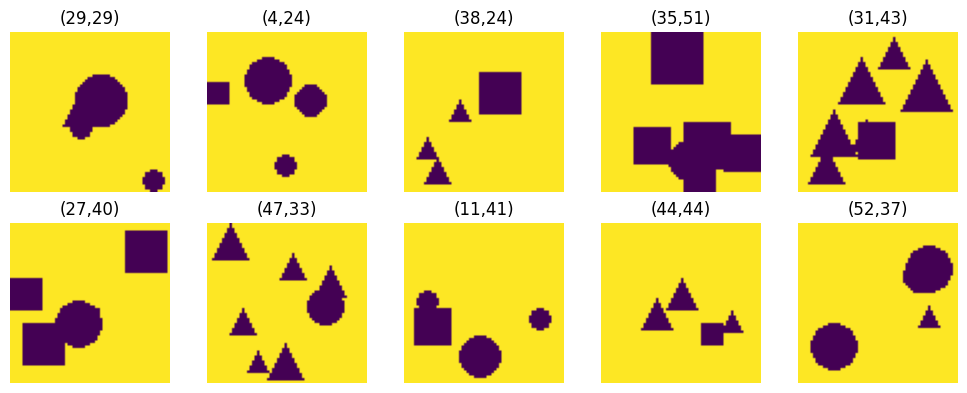

In [12]:
# ============================================================
# 0. Imports & device
# ============================================================
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np)#, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

In [13]:
import torch
import random
import numpy as np
SEED = 123
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")


positional_encoding_B = 1000

def sinusoid_positions(max_len = 144, dim = 16):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: pixels, features  (constant matrix throuoght all computations)

S = sinusoid_positions(144,16) # size: words, features
sine = S[:, ::2]
cosine = S[:, 1::2]



#Precalculated centers grid
ker_size = 20
stride = 4
grid = torch.arange(12)    # 0,1,...,11
centers_1d = grid * stride + (ker_size - 1) / 2        # 12 centers: 9.5, 13.5, ..., 53.5

# Siatka 12×12 -> (144,2)
yy, xx = torch.meshgrid(centers_1d, centers_1d, indexing='ij')
centers_xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # (144,2)


Working on cpu


In [22]:
#Model
import torch.nn as nn
import torch.nn.functional as F

# Convolution and positional encoding
class ConvAndPE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, 
                            out_channels=16, 
                            kernel_size=ker_size, # 64x64x1 -> 12x12x16
                            padding=0,
                            stride=stride,       
                            bias=True)
        # Save to buffer, move to GPU and dont learn it
        self.register_buffer("pos_enc", sinusoid_positions(144, 16))



    def forward(self, x):
        print(x)
        x = self.conv1(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_enc
        return x

# One attention block
class SelfAttBlock(nn.Module):

    def __init__(self, d = 16, n_heads = 4, ffn_mult = 4):
        # Model from "Attention is all you need"
        super().__init__()
        self.mha = nn.MultiheadAttention(d, n_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d, ffn_mult * d),
            nn.ReLU(),
            nn.Linear(d, ffn_mult * d),
        )
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)

    def forward(self, x, ret_att = False):
        y, att = self.mha(x ,x, x, need_weights = ret_att)
        x = self.norm1(x + y)
        y = self.ffn(x)

        out = self.norm2(x+y)

        if ret_att:
            return out, att
        return out  

# N * repeated attention block
class AttEncoder(nn.Module):
    def __init__(self, depth = 4, d = 16, n_heads = 4):
        super().__init__()
        self.layers = nn.ModuleList([SelfAttBlock(d,n_heads) for _ in range(depth)])    

    def forward(self, x, ret_att=False):
        att_last = None
        #We want attention from last layer
        for i, layer in enumerate(self.layers):
            is_last = (i == len(self.layers)-1)
            if ret_att and is_last:
                x, att_last = layer(x, ret_att = True)
            else:
                x = layer(x)
        
        if ret_att:
            return x, att_last
        return x


class OddShapeDetector(nn.Module):
    def __init__(self, centers_xy):
        super().__init__()
        self.cnn = ConvAndPE()
        self.encoder = AttEncoder()
        self.cls = nn.Sequential(
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
        self.register_buffer("centers_xy", centers_xy)

    def forward(self, img, ret_att=False):
        x = self.cnn(x)
        x, att = self.encoder(x, ret_att)

        logits = self.cls(x)
        print("Logits")
        print(logits)
        print(logits.shape)
        probs = logits.softmax(-1)
        print("Probs")
        print(probs)
        print(probs.shape)
        # pred_receptive_field = 
        


In [23]:
#Train
dataset = OddXYDataset(num_samples=10)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

net = OddShapeDetector(centers_xy).to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(2):

    # loss = 0.0
    for images, labels in dataloader:
        batch_inputs, batch_labels = images, labels # shape (B, 1, 64, 64), (B, 2)
                                                    #                           xy
        
        batch_inputs = batch_inputs.to(device) 
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)
        print(batch_outputs.shape)
        # loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels) 

        # print("epoch:", epoch, "current batch loss:", loss.item())
        # loss.backward()       
        # optimizer.step()     

UnboundLocalError: cannot access local variable 'x' where it is not associated with a value